In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [6]:
engine.table_names()

['measurement', 'station']

In [7]:
query = 'SELECT date, prcp FROM measurement LIMIT 5'

In [8]:
df = pd.read_sql_query(query, con=engine)

In [9]:
df.to_dict(orient='records')

[{'date': '2010-01-01', 'prcp': 0.08},
 {'date': '2010-01-02', 'prcp': 0.0},
 {'date': '2010-01-03', 'prcp': 0.0},
 {'date': '2010-01-04', 'prcp': 0.0},
 {'date': '2010-01-06', 'prcp': nan}]

In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
md = sqlalchemy.MetaData()
table = sqlalchemy.Table('measurement', md, autoload=True, autoload_with=engine)
columns = table.c
for c in columns:
    print(columns)

['measurement.id', 'measurement.station', 'measurement.date', 'measurement.prcp', 'measurement.tobs']
['measurement.id', 'measurement.station', 'measurement.date', 'measurement.prcp', 'measurement.tobs']
['measurement.id', 'measurement.station', 'measurement.date', 'measurement.prcp', 'measurement.tobs']
['measurement.id', 'measurement.station', 'measurement.date', 'measurement.prcp', 'measurement.tobs']
['measurement.id', 'measurement.station', 'measurement.date', 'measurement.prcp', 'measurement.tobs']


In [15]:
engine.execute('SELECT * FROM measurement ORDER BY date DESC').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0),
 (19548, 'USC00516128', '2017-08-21', 0.56, 76.0),
 (2721, 'USC00519397', '2017-08-20', 0.0, 81.0),
 (7633, 'USC00514830', '2017-08-20', 0.01, 80.0),
 (19547, 'USC00516128', '2017-08-20', None, 78.0),
 (2720, 'USC00519397', '2017-08-19', 0.0, 79.0),
 (7632, 'USC00514830', '2017-08-19', 0.0, 80.0),
 (12184, 'USC00519523', '2017-08-19', None, 85.0),
 (19546, 'USC00516128', '2017-08-19', 0.09, 71.0),
 (2719, 'USC00519397', '2017-08-18', 0.0, 80.0),
 (7631, 'USC00514830', '2017-08-18', 0.0, 77.0),
 (

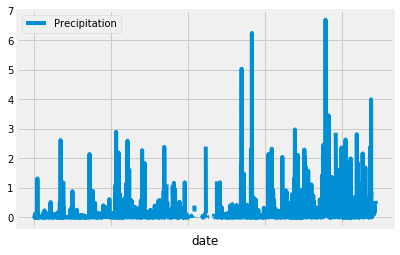

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

year = dt.datetime(2016, 8, 23)
 
# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year).all()

prcp = list(np.ravel(results))

date = prcp[::2]

prc = prcp[1::2]

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame({'date':date,'Precipitation':prc})

df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data

df.plot(x='date', y='Precipitation')


In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# How many stations are available in this dataset?
stations = session.query(func.count(distinct(Measurement.station)))
for station in stations:
    print(station)

(9,)


In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
active = session.query(*sel).filter_by(station = 'USC00519281').all()
active

[(54.0, 85.0, 71.66378066378067)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122152d30>]],
      dtype=object)

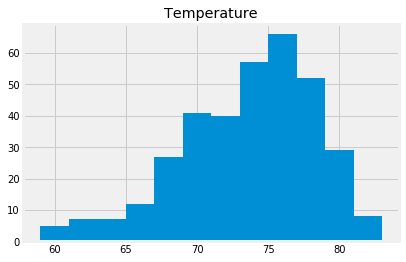

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.tobs).filter(Measurement.date > year).\
filter(Measurement.station == 'USC00519281').all()

highest = list(np.ravel(results))
df2 = pd.DataFrame({'Temperature':highest})
df2.hist(bins=12)

In [24]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# temps = temps[0]
tmin, tavg, tmax = calc_temps('2017-07-01', '2017-08-15')[0]

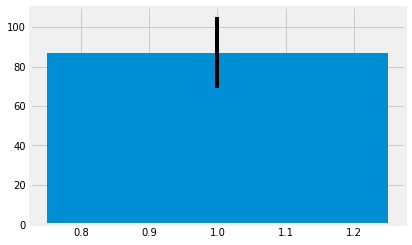

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(1, tmax, yerr=tmax-tmin, width=0.5)
plt.show()

In [27]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
       func.sum(Measurement.prcp)]

rainfall = session.query(*sel).filter(Measurement.date >= '2017-07-01').filter(Measurement.date <= '2017-08-15').\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp)).all()

rainfall

[('USC00517948',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.09),
 ('USC00519397',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.319999999999986),
 ('USC00519523',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.849999999999996),
 ('USC00513117',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  19.43999999999996),
 ('USC00514830',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  24.930000000000057),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  36.81000000000001),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  145.52999999999997)]